In [3]:
# import lib
# ===========================================================
import csv
import pandas as pd
from datascience import *
import numpy as np
import random
import time
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
import collections
import math
import sys
from tqdm import tqdm
from time import sleep

In [4]:
# Initialize useful data
# ===========================================================
df = pd.read_csv('clinvar_conflicting_clean.csv', low_memory=False)
columns_to_change = ['ORIGIN', 'EXON', 'INTRON', 'STRAND', 'LoFtool', 'CADD_PHRED', 'CADD_RAW', 'BLOSUM62']
df[['CLNVI', 'MC', 'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 
 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 
 'BAM_EDIT', 'SIFT', 'PolyPhen']] = df[['CLNVI', 'MC', 'SYMBOL', 'Feature_type', 'Feature', 'BIOTYPE', 
 'cDNA_position', 'CDS_position', 'Protein_position', 'Amino_acids', 'Codons', 
 'BAM_EDIT', 'SIFT', 'PolyPhen']].fillna(value="null")
# df_zero = df.loc[df['CLASS'] == 0]
# df_zero = df_zero.sample(n=10000)
# df_one = df.loc[df['CLASS'] == 1]
# df_one = df_one.sample(n=10000)

# df = pd.concat([df_zero, df_one])
df = df.sample(n = df.shape[0])
all_rows = df.values.tolist()
row_num = len(all_rows)
df.head()

,CHROM,POS,REF,ALT,AF_ESP,AF_EXAC,AF_TGP,CLNDISDB,CLNDN,CLNHGVS,...,Codons,STRAND,BAM_EDIT,SIFT,PolyPhen,LoFtool,CADD_PHRED,CADD_RAW,BLOSUM62,CLASS
54426,17,59763229,A,T,0.0002,0.00001,0.0000,"MedGen:C0027672,SNOMED_CT:699346009|MedGen:C03...",Hereditary_cancer-predisposing_syndrome|Famili...,NC_000017.10:g.59763229A>T,...,cTa/cAa,-1.0,null,tolerated_low_confidence,possibly_damaging,0.64000,0.704,-0.288928,-2.0,0
5039,2,44223046,G,C,0.0141,0.00226,0.0256,"MedGen:C0023264,OMIM:256000,Orphanet:ORPHA506,...",Leigh_syndrome|not_specified,NC_000002.11:g.44223046G>C,...,gCc/gGc,-1.0,OK,tolerated,benign,0.79200,9.852,0.863795,NaN,0
53637,17,41256896,G,C,0.0000,0.00000,0.0000,"MedGen:C0027672,SNOMED_CT:699346009|MedGen:C06...",Hereditary_cancer-predisposing_syndrome|Heredi...,NC_000017.10:g.41256896G>C,...,aCa/aGa,-1.0,OK,deleterious,probably_damaging,0.00207,26.200,5.477346,-1.0,0
62170,22,19902743,G,C,0.0000,0.00000,0.0000,"EFO:EFO_0000407,Human_Phenotype_Ontology:HP:00...",Primary_dilated_cardiomyopathy|not_specified,NC_000022.10:g.19902743G>C,...,ccC/ccG,-1.0,null,null,null,0.59700,8.830,0.700454,NaN,0
2121,1,103345315,C,T,0.0002,0.00044,0.0000,"MedGen:C0265235,OMIM:154780,SNOMED_CT:33410002...",Marshall_syndrome|Fibrochondrogenesis|not_spec...,NC_000001.10:g.103345315C>T,...,cGc/cAc,-1.0,null,tolerated,benign,0.00944,24.500,4.658146,NaN,0


In [10]:
# Decision stump part for Random Forest
# ===========================================================
def is_numeric(value):
    return isinstance(value, int) or isinstance(value, float)

# === LeafNode is the prediction result of this branch ===
class LeafNode:
    def __init__(self, rows):
        labels = [row[-1] for row in rows]
        self.prediction = collections.Counter(labels)

# === DecisionNode is an attribute / question used to partition the data ===
class DecisionNode:
    def __init__(self, question = None, left_branch = None, right_branch = None):
        self.question = question
        self.left_branch = left_branch
        self.right_branch = right_branch
    
class DecisionTree:
    def __init__(self, all_attribs, training_attribs, training_data, method = "CART"):
        self.attribute = training_attribs     # takein attribute and data separately
        self.train = training_data
        self.row_num = len(self.train)
        self.attribute_colNums = [all_attribs.index(att) for att in training_attribs]
        self.method = method.upper()            # convert to upper case for general use
        self.labels = self.uniq_val(-1)
        if self.method not in ["C4.5", "CART", "HYBRID"]:
            print("Error: Please choose a valid method!")
            return None
        self.root = self.build_tree(self.train)
    
    def uniq_val(self, column):
        return set([self.train[i][column] for i in range(len(self.train))])
    
    # === when raising a question ===
    # if it's a categorical attribute, we simply iterate all categories
    # if it's a numeric attribute, we iterate the set of possible numeric values 
    class Question:
        def __init__(self, column, ref_value):
            self.column = column
            self.ref_value = ref_value if ref_value else "None"
#             self.attri = attribute

        def match(self, row):
            if is_numeric(self.ref_value):
                try:
                    return row[self.column] >= self.ref_value
                except:
                    print("Error occured in ", row)
                    return True
            else:
                return row[self.column] == self.ref_value

        def __repr__(self):
            operand = ">=" if is_numeric(self.ref_value) else "=="
            return "Is %s %s %s?" % (self.attri[self.column], operand, str(self.ref_value))
    
    # === Method 1 - C4.5 ===
    def entropy(self, rows):
        # === Bits used to store the information ===
        labels = [row[-1] for row in rows]
        frequency = collections.Counter(labels).values()
        pop = sum(frequency)
        H = 0
        for f in frequency:
            p = f / pop
            H -= p * math.log(p, 2)
        return H
    
    # === Method 2 - CART ===
    def gini(self, rows):
        # === Probability of misclassifying any of your label, which is impurity ===
        labels = [row[-1] for row in rows]
        frequency = collections.Counter(labels).values()
        pop = sum(frequency)
        gini = 1
        for f in frequency:
            p = f / pop
            gini -= p ** 2
        return gini
    
    # === Calculate Gain Info ===
    # I'm actually returning the gain info reduction
    def info(self, branches, root):
        # === Objective: to find the best question which can maximize info ===
        root_size = float(len(root))
        if self.method == "C4.5":  # Here I pick the GainRatio Approach
            root_uncertainty = self.entropy(root)
            gain_info = root_uncertainty
            split_info = 0
            for branch in branches:
                if not branch: continue
                gain_info -= len(branch) / root_size * self.entropy(branch)
                split_info -= float(len(branch)) / root_size * math.log(float(len(branch)) / root_size)
#                 print(gain_info, split_info)
            return gain_info / split_info
        elif self.method == "CART":
            root_uncertainty = self.gini(root)
            gain_info = root_uncertainty
            for branch in branches:
                if not branch: continue
                gain_info -= len(branch) / root_size * self.gini(branch)
            return gain_info
        elif self.method == "HYBRID":
            pass
        pass
    
    # Divide rows according to the question to true_rows and false_rows
    # === Here I only do Binary Partitions ===
    def partition(self, rows, question):
        true_rows = []
        false_rows = []
        for row in rows:
            if question.match(row):
                true_rows.append(row)
            else:
                false_rows.append(row)
        return true_rows, false_rows
    
    def find_best_question(self, rows):
        max_info_attenuation = 0
        best_question = self.Question(self.attribute_colNums[0], self.train[0][self.attribute_colNums[0]])
        # === Iterate through all question candidates ===
        # === TODO: Maybe Iteration here can be optimized ===
        for col in self.attribute_colNums: # minus 1 to avoid using the label as attribute
            ref_candidates = self.uniq_val(col)
            for ref_value in ref_candidates:
                if ref_value == "null" or not isinstance(ref_value, str) and np.isnan(ref_value): continue # avoid using null values to generate a question
                q = self.Question(col, ref_value)
                temp_true_rows, temp_false_rows = self.partition(rows, q)
                temp_info_attenuation = self.info([temp_true_rows, temp_false_rows], rows)
                if temp_info_attenuation >= max_info_attenuation:
                    max_info_attenuation = temp_info_attenuation
                    best_question = q
        return max_info_attenuation, best_question
    
    # === Input rows of data with attributes and labels ===
    def build_tree(self, rows):
        # === Assign all rows as root of the whole decision tree ===
        # === We have met the leaf node if gini(rows) is 0 or no question candidates left ===
        gain_reduction, q = self.find_best_question(rows)
        # gain here is actually info reduction
        if gain_reduction <= 0.001:
            return LeafNode(rows)
        true_rows, false_rows = self.partition(rows, q)
        # === Recursion after we have found a optimal question ===
        return DecisionNode(q, self.build_tree(true_rows), self.build_tree(false_rows))
    
    # === Input a row of data with attributes (and no label), predict its label with our decision tree ===
    # === Actually it can contain a label, we just don't use it ===
    # === walk down the decision tree until we reach the leaf node ===
    def classify(self, row, node):
        if isinstance(node, LeafNode):
#             print("===", node.prediction)
            return node.prediction
        
        if node.question.match(row):
#             print(node.question, True)
            return self.classify(row, node.left_branch)
        else:
#             print(node.question, False)
            return self.classify(row, node.right_branch)
    
    def print_tree(self, node, spacing=""):
        # Base case: we've reached a leaf
        if isinstance(node, LeafNode):
            print (spacing + "Predict", node.prediction)
            return

        # Print the question at this node
        print (spacing + str(node.question))

        # Call this function recursively on the true branch
        print (spacing + '--> True:')
        self.print_tree(node.left_branch, spacing + "  ")

        # Call this function recursively on the false branch
        print (spacing + '--> False:')
        self.print_tree(node.right_branch, spacing + "  ")
    
'''    def test(self):
        for i in range(self.column_num):
            q = self.Question(i, self.train[1][i], self.attribute)
            print(q)
            print(q.match(1))'''
    
def bootstrapped_dataset(rows, size):
    n = len(rows)
    bootstrapped_rows = []
    # here i should pick rand_idx with replacement, which is bootstrapping
    rand_idx = np.random.choice(n, size, replace=True)
    for i in rand_idx:
        bootstrapped_rows.append(rows[i])
    return bootstrapped_rows

In [11]:
# Divide whole dataset into training set and testing set
# ===========================================================
training_percentage = 0.01  # percent of partition of training dataset
training_size = int(row_num * training_percentage)
testing_size = row_num - training_size
training_attribute = list(df.columns)
training_data = all_rows[: training_size]  # training data should include header row
testing_data = all_rows[training_size: ]   # testing data don't need to include header row

In [12]:
# Training Random Forest
# ===========================================================
rand_attribute_subset_len = 5
# for fixed_attribute in training_attribute:
fixed_attribute = training_attribute[0]
remaining_attribute = list(training_attribute)[: -1]  # here i should manually omit the 'CLASS' column
remaining_attribute.remove(fixed_attribute)

random_forest = []
start = time.time()

for i in range(10):
    sys.stdout.write('\r')
    # the exact output you're looking for:
    sys.stdout.write("Training Random Forest: [%-10s] %d%%" % ('='*(i + 1), (i + 1) * 10))
    sys.stdout.flush()
    rand_attribute_subset = np.random.choice(a=remaining_attribute, size=rand_attribute_subset_len)
    rand_attribute_subset = np.append(rand_attribute_subset, fixed_attribute)
    training_data = bootstrapped_dataset(all_rows, training_size)
#     print(np.bincount([row[-1] for row in training_data]))
    tree = DecisionTree(training_attribute, rand_attribute_subset, training_data, "CART")
#     tree.print_tree(tree.root)
    random_forest.append(tree)
end = time.time()
print("Random Forest Trained! Time: %.03fs" % (end - start))

[497 154]
[475 176]
[492 159]
[483 168]
[488 163]
[469 182]
[454 197]
[495 156]
[488 163]
[485 166]
Random Forest Trained! Time: 366.610s


In [13]:
# Testing Random Forest, Computing TN, TP, FN, FP, etc.
# ===========================================================

ROC = Table(make_array('CUTOFF', 'TN', 'FN', 'FP', 'TP', 'ACC'))
step_size = 0.05
forest_size = len(random_forest)
CMap = {0: 'TN', 1: 'FN', 2: 'FP', 3: 'TP'}
for cutoff in np.arange(0, 1 + step_size, step_size):
    sys.stdout.write('\r')
    # the exact output you're looking for:
    sys.stdout.write("Testing: [%-20s] %d%%" % ('='*int(cutoff * 100 / 5), int(cutoff * 100)))
    sys.stdout.flush()
    
    Confusion = {'TN': 0, 'FN': 0, 'FP': 0, 'TP': 0}
    for row in testing_data:
        true_rate_forest = 0
        for tree_i in random_forest:
            
            # prediction is a counter of label 1 and 0
            pred_counter = tree_i.classify(row, tree_i.root)
            true_rate_tree = pred_counter.get(1, 0) / (pred_counter.get(1, 0) + pred_counter.get(0, 0) + 0.00000001)
            true_rate_forest += true_rate_tree
        true_rate_forest /= forest_size
        true_pred = 1 if true_rate_forest >= cutoff else 0
        indicator = (true_pred << 1) + row[-1]
        
        # accordingly update confusion matrix
        Confusion[CMap[indicator]] += 1
        
    # concatenate the confusion matrix values into the overall ROC Table
    thisline = [cutoff] + list(Confusion.values()) + [(Confusion['TP'] + Confusion['TN']) / sum(Confusion.values())]
    ROC = ROC.with_row(thisline)
ROC = ROC.with_columns('SENSITIVITY', ROC.apply(lambda TP, FN: TP / (TP + FN + 0.00000001), 'TP', 'FN'))
ROC = ROC.with_columns('FPR', ROC.apply(lambda TN, FP: FP / (TN + FP + 0.00000001), 'TN', 'FP'))
ROC = ROC.with_column('FMEAS', ROC.apply(lambda TP, FP, FN: 2 * (TP / (TP + FN)) * (TP / (TP + FP)) / (TP / (TP + FN) + TP / (TP + FP)), 'TP', 'FP', 'FN'))

/Users/frostace/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


In [14]:
ROC.show()

CUTOFF,TN,FN,FP,TP,ACC,SENSITIVITY,FPR,FMEAS
0,0,0,48264,16273,0.25215,1,1,0.402747
0.05,14158,2516,34106,13757,0.432543,0.845388,0.706655,0.428995
0.1,19856,4084,28408,12189,0.496537,0.749032,0.588596,0.428662
0.15,30909,6947,17355,9326,0.623441,0.573097,0.359585,0.434232
0.2,35629,9158,12635,7115,0.662318,0.437227,0.261789,0.395025
0.25,41666,11482,6598,4791,0.719851,0.294414,0.136706,0.346396
0.3,44225,13405,4039,2868,0.729705,0.176243,0.0836856,0.247455
0.35,46317,14465,1947,1808,0.745696,0.111104,0.0403406,0.180547
0.4,47365,15492,899,781,0.746022,0.0479936,0.0186267,0.087005
0.45,47811,15805,453,468,0.748082,0.0287593,0.00938588,0.0544376


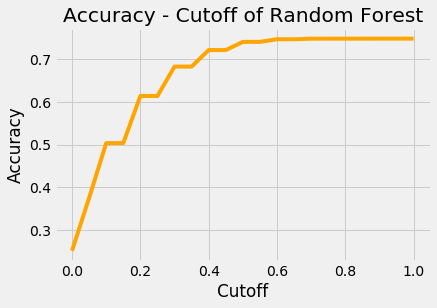

In [130]:
# Acc Curve by cutoff
# ===========================================================
fig = plt.figure()
plt.xlabel('Cutoff')
plt.ylabel('Accuracy')
plt.title('Accuracy - Cutoff of Random Forest')
plt.plot(ROC.column('CUTOFF'), ROC.column('ACC'), color='orange')
# plt.plot(ROC.column('CUTOFF'), ROC.column('FMEAS'), color='blue')
# plt.legend(['Acc', 'F1-score'])
plt.show()
fig.savefig('Random Forest ACC.png', bbox_inches='tight')

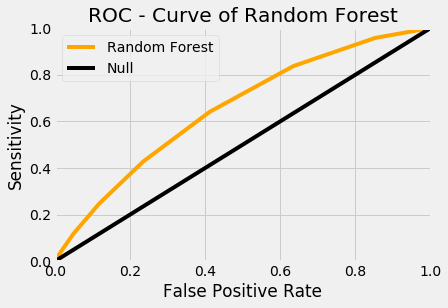

In [110]:
# ROC_CURVE
# ===========================================================
fig = plt.figure()
plt.xlabel('False Positive Rate')
plt.ylabel('Sensitivity')
plt.title('ROC - Curve of Random Forest')
plt.plot(ROC.column('FPR'), ROC.column('SENSITIVITY'), color='orange')
plt.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), color='black')
plt.legend(['Random Forest', 'Null'])
plt.axis([0, 1, 0, 1])
plt.show()
fig.savefig('Random Forest ROC.png', bbox_inches='tight')

In [111]:
# Compute AUC
# ===========================================================
length = len(ROC.column('FPR'))
auc = 0
for i in range(length - 1):
    auc += 0.5 * abs(ROC.column('FPR')[i + 1] - ROC.column('FPR')[i]) * (ROC.column('SENSITIVITY')[i] + ROC.column('SENSITIVITY')[i + 1])
print("auc = %.03f" %auc)

auc = 0.654


In [35]:
# Original Testing Random Forest
# ===========================================================
forest_acc = []
for tree_i in random_forest:
    accuracy = []
    for row in training_data:
        classification = tree_i.classify(row, tree_i.root)
        if len(classification) == 1:
    #         print("======", row, tree.classify(row, tree.root).get(row[-1], 0))
            accuracy.append(int(classification.get(row[-1], 0) > 0))
        else:
    #         print("======", row, tree.classify(row, tree.root).get(row[-1], 0))
            tot = sum(classification.values())
            accuracy.append(classification.get(row[-1], 0) / tot)
    forest_acc.append(sum(accuracy) / len(accuracy))
print(np.average(forest_acc))
end = time.time()
print("time = %.03fs" % (end - start))

0.8288292241411295
time = 131.254s


In [55]:
# sklearn lib version
# ===========================================================
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
df = pd.read_csv('clinvar_conflicting_mapped.csv', low_memory=False)
df.head()
df = df.sample(n = df.shape[0])
all_rows = df.values.tolist()
row_num = len(all_rows)

training_percentage = 0.01  # percent of partition of training dataset
training_size = int(row_num * training_percentage)
testing_size = row_num - training_size
training_attribute = list(df.columns)
training_data = all_rows[: training_size]  # training data should include header row
testing_data = all_rows[training_size: ]   # testing data don't need to include header row

In [56]:
# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)
X = [row[: -1] for row in training_data]
Y = [row[-1] for row in training_data]
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, Y)

/Users/frostace/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [57]:
test = [row[: -1] for row in testing_data]
actual_label = [row[-1] for row in testing_data]
result = clf.predict(test)

In [58]:
accuracy = 0
for i in range(len(result)):
    accuracy += int(result[i] == actual_label[i])
accuracy /= len(result)
accuracy

0.7480670003253947

In [74]:
def test(p):
    return 2 * p * (1 - p)

In [79]:
test(0.999)

0.001998000000000002

In [96]:
# training_attribute - acc
attribute_acc = [0.6742062692718905, 0.6754536157553033, 0.6850566341788431, 0.7187853479399414, 0.704456358368068, 0.7360932488340022, 0.6692362520724545, 0.7198041433596231, 0.6726528967878891, 0.6803306630305095, 0.6753761408184452, 0.7310651254319227, 0.7217642592621287, 0.7095270929854193, 0.7073268047786541, 0.6674039698157647, 0.7182546446224646, 0.7231936718471574, 0.7169724344174659, 0.6964764398717016, 0.7249174891922463, 0.7072841935633822, 0.6843128747850071, 0.7285239475029828, 0.6901080000619799, 0.714163967956366, 0.7057928010288672, 0.6890775834017695, 0.7248981204580318, 0.6749965136278414, 0.7111385716720642, 0.7120217859522444, 0.6904372685436262, 0.7136371383857323, 0.7124672668391775, 0.7131412987898414] 
importance = Table().with_columns('ATT', training_attribute[: -1], 'ACC', attribute_acc)

In [100]:
importance.sort('ACC', descending=True).show(5)

ATT,ACC
AF_EXAC,0.736093
CLNVI,0.731065
cDNA_position,0.728524
BIOTYPE,0.724917
STRAND,0.724898


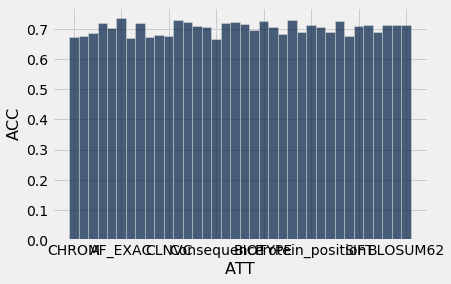

In [99]:
importance.bar('ATT')

In [131]:
a, b = ROC.column('CUTOFF'), ROC.column('ACC')

In [132]:
a

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ])

In [133]:
b

array([0.25238235, 0.37572245, 0.50361808, 0.50361808, 0.61374095,
       0.61374095, 0.68238375, 0.68238375, 0.72096627, 0.72096627,
       0.74007159, 0.74007159, 0.74619211, 0.74619211, 0.74754017,
       0.74754017, 0.74755567, 0.74755567, 0.74764864, 0.74764864,
       0.74761765])